In [67]:
#allow file access
from google.colab import files

from tensorflow.keras.models import load_model

import pickle

#import shap  
#import shap
#shap.initjs()

import pandas as pd
import tensorflow as tf
#tf.compat.v1.disable_v2_behavior() #this was required for SHAP values
#possibly worth using the below 
#tf.compat.v1.enable_eager_executionconfig=None, device_policy=None, execution_mode=None)
from tensorflow import keras


#borrowed form 5c16
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from keras.models import model_from_json

from tensorflow.keras.callbacks import CSVLogger

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

#r2 score
#from keras import backend as K
import tensorflow.keras.backend as K
from sklearn.metrics import r2_score

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

#model optimisation api
#import tensorflow_model_optimization as tfmot

import tempfile
import os
import zipfile

%load_ext tensorboard

from tabulate import tabulate

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [68]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        self.metrics = []
        self.val_metrics = []
        

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('r_squared'))
        self.val_acc.append(logs.get('val_r_squared'))
        ###
        self.metrics.append(logs.get('mean_absolute_percentage_error'))         #mean_squared_error
        self.val_metrics.append(logs.get('val_mean_absolute_percentage_error')) #val_mean_squared_error
        
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(60, 20))
        plt.plot([3, 1])

        #plot 1 mean absolute percentage error
        plt.subplot(131) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('Mse')
        plt.xlabel('epoch')
        plt.title('MSE Value')
        plt.legend()

        #plot 2 r squared value
        plt.subplot(133)         
        plt.plot(self.x, self.acc, label="training r-squared")
        plt.plot(self.x, self.val_acc, label="validation r-squared")
        plt.legend()
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('R-squared')
        plt.xlabel('epoch')
        plt.title('R-Squared Value')

        #plot 3 mean squared error
        plt.subplot(132)         
        plt.plot(self.x, self.metrics, label="training mse")
        plt.plot(self.x, self.val_metrics, label="validation mse")
        plt.legend()
        plt.ylabel('Mean absolute percentage Error')
        plt.xlabel('epoch')
        plt.title('Mean absolute percentage Error')
        
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();
        

#creating a r^2 metric for the model evaluation
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

    

In [69]:
ch_names = np.arange(44).tolist()
freqs = np.arange(191.6, 195.9, 0.1).tolist()
for x in range(len(ch_names)):
  ch_names[x] = "Ch %.0f (%.1f)" % (ch_names[x], freqs[x])

In [70]:
#generate the train and testing datasets
#retreiving both datasets from GitHub
git_xval = 'https://raw.githubusercontent.com/p-owens/MAI/main/x_val.csv'
git_yval = 'https://raw.githubusercontent.com/p-owens/MAI/main/y_val.csv'
df_x = pd.read_csv(git_xval,
                  index_col=False,
                  header=None,
                  names=ch_names)

df_y = pd.read_csv(git_yval,
                  index_col=False,
                  header=None,
                  names=ch_names)

#dropping the frequences row for each training sample
df_x = df_x.iloc[1::2]
#print(df_x)

In [71]:
#select a channel to operate on
ch = 39

In [72]:
#drop all rows where df_x has a value != 0
df_chx = df_x[df_x[ch_names[ch]] !=0]
df_chy = df_y[df_y[ch_names[ch]] !=0]
df_chy = df_chy[ch_names[ch]]

#convert to numpy arrays
x_values = df_chx.to_numpy()
y_values = df_chy.to_numpy()


val_split = .2

#generate the test/validation split
#x_rem, x_test, y_rem, y_test = skl.model_selection.train_test_split(x_values, y_values, test_size=.2, random_state=0)
x_train, x_val, y_train, y_val = skl.model_selection.train_test_split(x_values, y_values, test_size = val_split, random_state = 0)#renaimed x_rem and y_rem to x_values and y_values


In [73]:
print(y_train[30:75])

[ 7.34257874  5.97724146  8.65406006  6.42952873  7.60681135  7.16922936
  7.83781312  7.07160091  6.84364594  6.93991575  6.95120228  6.34390264
  4.96305588  7.12814705  7.09835973  7.34302169  5.6246438   6.78172137
  6.79042404  6.51512424  6.98634427 11.74410823  7.15268973  6.87408565
  6.98634427  7.34605956  9.29018874  7.12661317  6.99457008  5.00767038
  5.90024723  5.99097367  7.84145159  7.36429496  6.29340745  6.8040521
  9.00700699  8.76849208  7.76431772  5.2859368   4.20502545  6.54296004
  7.0579357   6.92478924  7.30788245]


In [104]:
#create the models
inputs = keras.layers.Input(shape=(44,))


x = Dense(360, activation='relu')(inputs)
x = Dropout(0.45)(x) # Drop out
x = Dense(180, activation='linear')(x)
x = Dropout(0.45)(x) # Drop out
x = Dense(180, activation='relu')(x)
x = Dropout(0.45)(x) # Drop out 
x = Dense(90, activation='linear')(x)
x = Dropout(0.4)(x) # Drop out
x = Dense(45, activation='relu')(x)
x = Dropout(0.2)(x) # Drop out 
predictions = Dense(1, activation='relu')(x)

l_rate = 1 * 1e-4

# we create the model 
model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = tf.keras.optimizers.Nadam(learning_rate=l_rate)

# setup the optimisation strategy
model.compile(optimizer=opt,
              loss='mean_squared_error',      #formerly mean_absolute_percentage_error
              metrics=[r_squared, tf.keras.metrics.MeanAbsolutePercentageError()]) #tf.keras.metrics.MeanAbsolutePercentageError()


model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 44)]              0         
_________________________________________________________________
dense_105 (Dense)            (None, 360)               16200     
_________________________________________________________________
dropout_85 (Dropout)         (None, 360)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 180)               64980     
_________________________________________________________________
dropout_86 (Dropout)         (None, 180)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 180)               32580     
_________________________________________________________________
dropout_87 (Dropout)         (None, 180)               0  

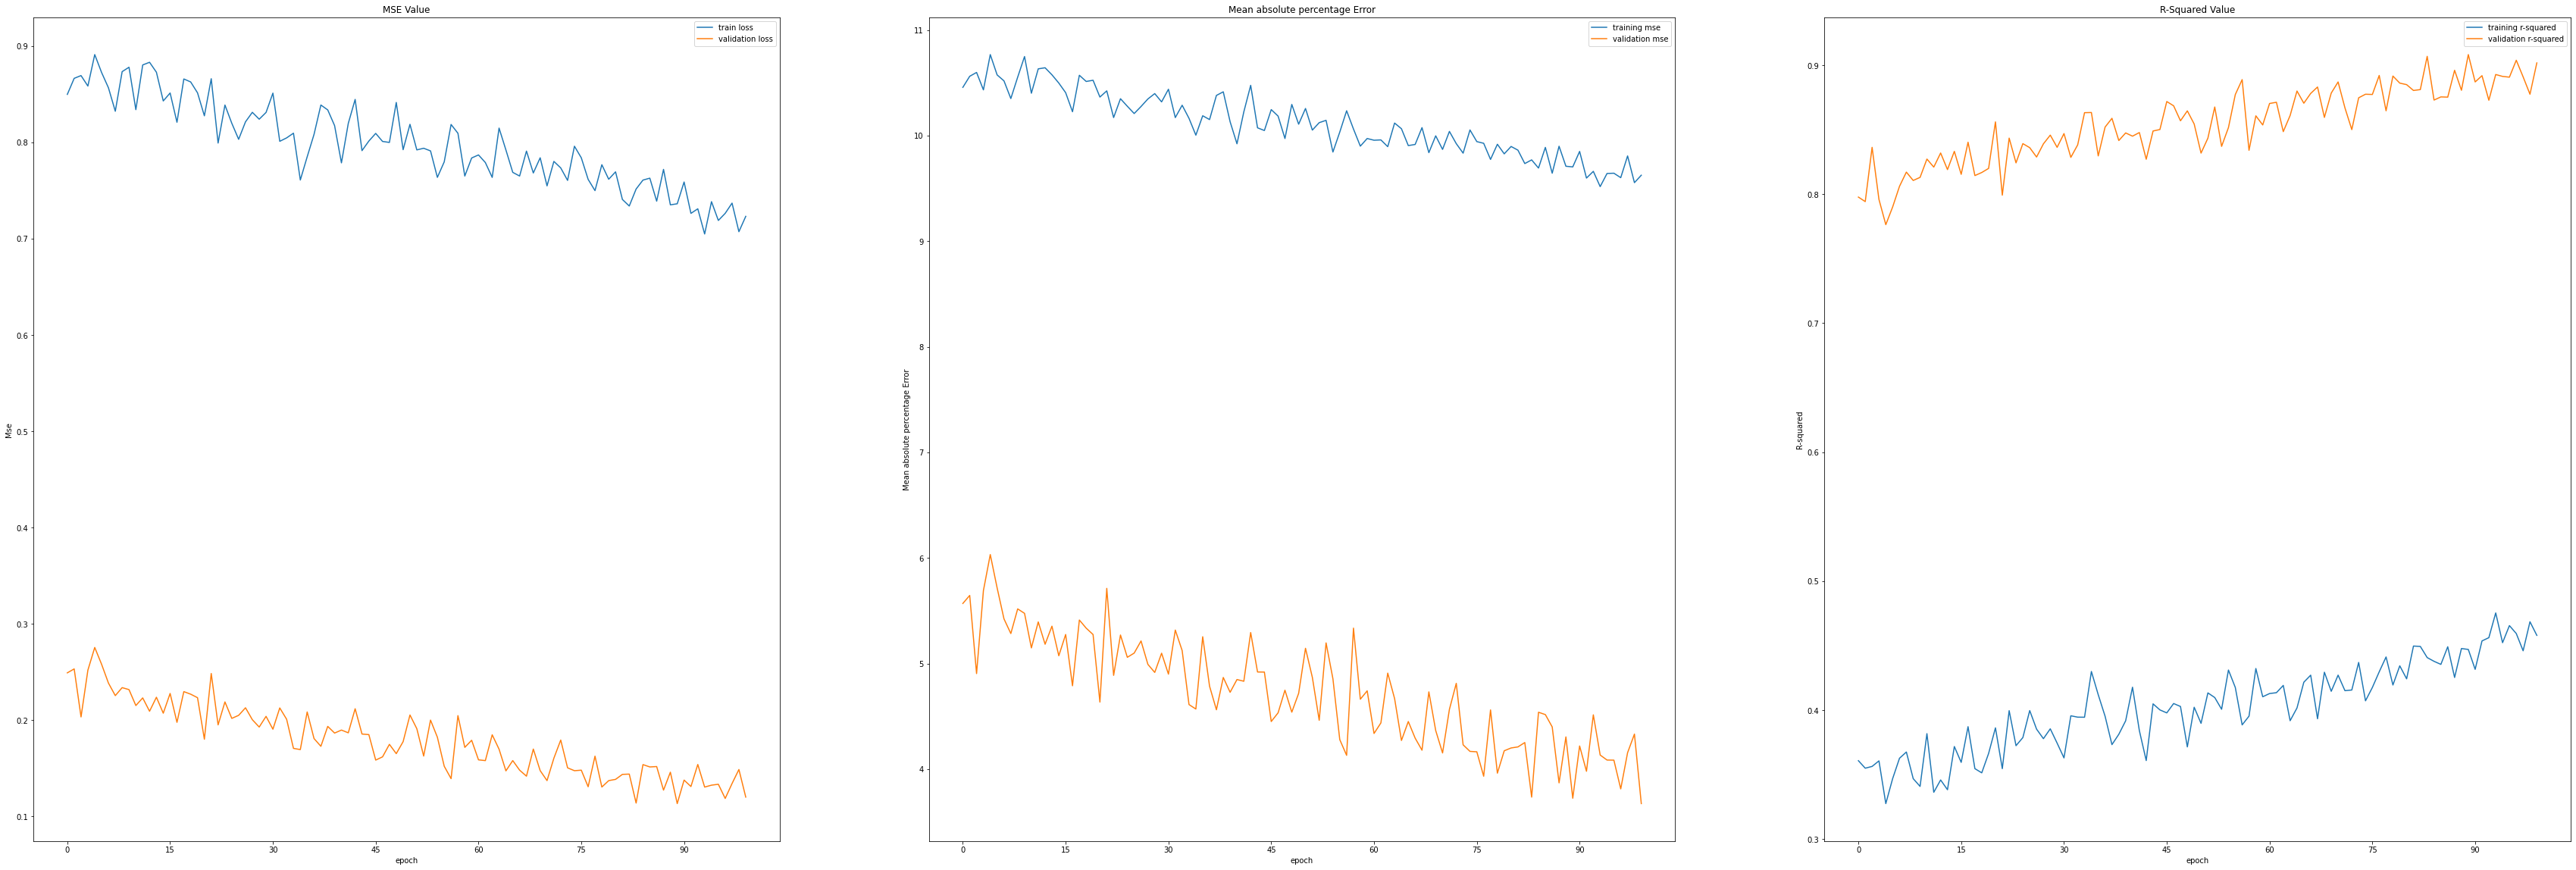

In [111]:
#callback for plotting the model metrics

path = 'model_checkpoints/ch_{0}_'.format(ch)
log_file = 'model_ch_{0}.csv'.format(ch)
csv_log = CSVLogger(log_file)

pltCallBack = PlotLossAccuracy()
#callback for saving the model
checkpoint = ModelCheckpoint(filepath= path + 'ep_{epoch:02d}_mse_{val_loss:.2f}_pct_err_{val_mean_absolute_percentage_error:.2f}.hdf5',
                             monitor='val_loss',
                             verbose=0,
                             save_weights_only=False,
                             save_best_only=True,
                             mode='min',
                             save_freq="epoch")

batchSize = 400

# and train
model.fit(x_train, y_train,
                    batch_size=batchSize, epochs=100,   #evaluate for 20 and then 230
                    validation_data=(x_val, y_val), 
                    callbacks=[pltCallBack, checkpoint, csv_log])

In [112]:
pd.read_csv(log_file, index_col='epoch')

,loss,mean_absolute_percentage_error,r_squared,val_loss,val_mean_absolute_percentage_error,val_r_squared
epoch,,,,,,
0,0.849775,10.456544,0.360746,0.249033,5.568773,0.797757
1,0.866447,10.561250,0.354926,0.253131,5.644625,0.794250
2,0.869310,10.597538,0.356302,0.203241,4.904530,0.836322
3,0.858440,10.432481,0.360602,0.251826,5.690827,0.795953
4,0.891121,10.766724,0.327476,0.275398,6.031782,0.776382
...,...,...,...,...,...,...
95,0.718855,9.643207,0.465486,0.133333,4.084745,0.890744
96,0.726249,9.601121,0.459350,0.118589,3.812598,0.903856
97,0.736861,9.806867,0.445962,0.134092,4.155436,0.890970


In [94]:
#Using a dataset with 1 ch constantly on for the test set
#retreiving both datasets from GitHub



git_xval = ('https://raw.githubusercontent.com/p-owens/MAI/main/data%20gen/ch{0}/x_val.csv'.format(40))
git_yval = ('https://raw.githubusercontent.com/p-owens/MAI/main/data%20gen/ch{0}/y_val.csv'.format(40)) #need to replace number with ch varble
dfx = pd.read_csv(git_xval,
                  index_col=False,
                  header=None,
                  names=ch_names                                   
                 )
dfy = pd.read_csv(git_yval,
                  index_col=False,
                  header=None,
                  names=ch_names
                 )

#dropping the frequences row for each training sample
dfx = dfx.iloc[1::2]

#drop all rows where df_x has a value != 0
dfx = dfx[df_x[ch_names[ch]] !=0]
dfy = dfy[df_y[ch_names[ch]] !=0]
dfy = dfy[ch_names[ch]]

x_test = dfx.to_numpy()
y_test = dfy.to_numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
print(pd.DataFrame(x_test))
print(pd.DataFrame(y_test))

In [95]:
#evaluate the model on the test set
results = model.evaluate(x_test,y_test, verbose=1)
print("{name1}\t\t: {mse:<.4f}\t(lower is better)\n{name2}\t: {r2:<.2%}\t(higher is better)".format(name1 = model.metrics_names[0],
                                                                                                    name2 = model.metrics_names[1],
                                                                                                    mse = results[0],
                                                                                                    r2 = results[1]))

8/8 [==============================] - 0s 2ms/step - loss: 4.9027 - r_squared: -1.3318 - mean_absolute_percentage_error: 25.4062
loss		: 4.9027	(lower is better)
r_squared	: -133.18%	(higher is better)
